# Unet for Mitosis Detection - MPSID thesis
- Library: Keras <br>
- Model: U-net <br>
- Language: Python 2.7 <br>
- Basado en https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras <br>
- Descripcion: Archivo creado para cargar UNA SOLA IMAGEN. <br>
- Se agrega el calculo del validation. <br>

### Import Libraries keras, opencv, tiff

In [13]:
__author__= "gabriel jimenez"

import numpy as np
import cv2
import pandas as pd
import tifffile as tiff
import os.path
import matplotlib.pyplot as plt
# import Image
import pickle

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

from keras import backend as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import multi_gpu_model
from keras.callbacks import Callback
from keras.utils import np_utils

%matplotlib inline

### Check save DIR
- Constants are defined. 
- numClassesDef is used to defined numer of classes and will be an input to the model.
- Check ISZ!!!!

In [171]:
# Numero de clases 0: non-mitosis 1: mitosis

# Path to the images and masks
imDir = '/home/gabriel/Documents/MPSID2018/mpsid-thesis-Gabo/masks-HPF/'
filesDir = '/home/gabriel/Documents/MPSID2018/mpsid-thesis-Gabo/'

# Path of the results to be saved depending of the image size and the classes
saveDir = './results/'
numClassesDef = 4  # it gets its value from the number of valid masks

# Run 
# 1: Prepare Data
# 2: Train using prepared data anda save weights 
# 3: Predict values

# size of the patches (square)
ISZ = 71 # Needed to be defined later, before training!!
smooth = 1e-12
overlap = 20 
split = 30 # Test

# number of EPOCHS
numEpochs = 100

### Build the Dataset 
 The paths of the rasters considered in the masks are read from a file
 if the line includes a # then it is skipped and joins the rasters in a matrix. <br>
 - Input: Text file containing the paths of the masks. <br> 
 - Returns: The mask of numClases dimensions. 


In [172]:
def joinMasks(file):
    
    # labels = ["Blured","Corn1", "Corn2", "Corn3","Corn4","Unknown","Potato","River","Road","Building"] 
    labels = ["nonmitosis", "mitosis"]
    numLabel = 0
    paths = []
    labelsPath = []
    numClasses = 0
    
    # The content of the file is read the path of the masks 
    # The paths are saved in the variable labelsPath
    # The number of labels keeps a count in numLabel
    with open(file, "r") as openFile:
        for fileName in openFile:
            if (fileName[0] != '#'):
                numClasses = numClasses + 1
                fileName = fileName[:-1]
                paths.append(fileName)
                labelsPath.append(labels[numLabel])
            numLabel = numLabel + 1
    
    # The paths are checked if they are valid
    print("\nValid Masks:")
    for i in range (0, numClasses):
        if(os.path.isfile(paths[i])):
                # The image is read
                img = tiff.imread(paths[i])
                
                if(i == 0): # if it is the first, the the matrix is created according to the number of classes
                    [m,n] = img.shape[0], img.shape[1]
                    mask = np.zeros([m,n,numClasses], dtype = 'uint8')
                mask[:,:,i] = img
                print paths[i], i ,labelsPath[i] 

    return mask

### Reads and shows an image
- Input: Raster name.
- Returns: an image given a name in the directory in 8 bits.

In [173]:
def readImage(file):
    fileName = imDir + file
    image = 0
    
    if(os.path.isfile(fileName)):
        print fileName
        image = tiff.imread(fileName)
        image = image[:,:,:5]
        image8 = (image/257).astype('uint8')
        print "\nImage shape", image8.shape
        # [m,n]=image8.shape[0], image8.shape[1]
        # imgMost=np.zeros([m,n,3], dtype='uint8')
        # imgMost[:,:,0]=image8[:,:,0]
        # imgMost[:,:,1]=image8[:,:,1]
        # imgMost[:,:,2]=image8[:,:,2]
        # plt.imshow(imgMost) 
        # cv2.namedWindow('Imagen',cv2.WINDOW_NORMAL)
        # cv2.resizeWindow('Imagen', 600,600)
        # cv2.imshow('Imagen',imgMost)	
            
        # cv2.waitKey(1000)
        # cv2.destroyAllWindows()
    
    return image8

- Se guarda en una matriz la imagen con las 5 bandas
y se guarda en una matriz las mascaras
- Se guardan en archivos npy totalX y totalY

In [174]:
def prepareTotalData():
    print 'Prepare the data'
    image060318e1 = readImage('/Huapra060318_escalonado1.tif')
    mask060318e1 = joinMasks(saveDir+'huapra060318_e1_mask.txt')
    
    print "Saving Image ..."
    print saveDir + 'data/totalX' 
    np.save(saveDir + 'data/totalX', image060318e1)
    print "Saving Masks ..."
    print saveDir + 'data/totalY'    
    np.save(saveDir + 'data/totalY', mask060318e1)
    print "Done"

### Patch generator
- Divide the DB in patches
- Input: overlap in %

In [175]:
def generatePatches():
    
    print "Dividing the image, using %d Overlap." %(overlap)
    print "Creating the DB: ISZ %dx%d ..." %(ISZ, ISZ)
    img = np.load(saveDir +'data/totalX.npy')
    rSize, cSize = img.shape[0], img.shape[1]
    mask = np.load(saveDir + 'data/totalY.npy')
    step = (1.0*ISZ)*(100-overlap)/100
    step = int(round(step))
    
    rBegP = 0
    rEndP = rBegP + ISZ
    rMax = rSize - ISZ
    
    cBegP = 0
    cEndP = cBegP + ISZ
    cMax = cSize - ISZ
    
    x,y = [], []

    print 'paso:', step, 'rEndP:', rEndP, 'rMax:', rMax, 'cEndP:', cEndP, 'cMax:', cMax

    # imgMost=np.zeros([ISZ,ISZ,3], dtype='uint8')
    # cv2.namedWindow('Imagen',cv2.WINDOW_NORMAL)
    # cv2.resizeWindow('Imagen', ISZ,ISZ)	
    
    while (cEndP < cMax):
        while(rEndP <rMax):
            #print 'rBegP:', rBegP, 'rEndP:', rEndP
            patchImg = img[rBegP:rEndP, cBegP:cEndP] 
            patchMask = mask[rBegP:rEndP, cBegP:cEndP]
            if (np.count_nonzero(patchImg[:,:,1]) != 0):
                x.append(patchImg)
                y.append(patchMask)
                
            # else:
            # imgMost[:,:,0]=patchImg[:,:,0]
            # imgMost[:,:,1]=patchImg[:,:,1]
            # imgMost[:,:,2]=patchImg[:,:,2]
            # print rBegP
            # cv2.imshow('Imagen',imgMost)
            # cv2.waitKey(100)

            rBegP = rBegP+step
            rEndP = rBegP+ISZ
        # print 'cBegP:', cBegP, 'cEndP:', cEndP
        cBegP = cBegP+step
        cEndP = cBegP +ISZ 
        rBegP = 0
        rEndP = rBegP+ISZ
   
    np.save(saveDir + 'data/xPatch%d'% overlap, x)
    np.save(saveDir + 'data/yPatch%d'% overlap, y)
    # cv2.destroyAllWindows()

### Distribute patches
- Splits the DB in training and test
- Input: Percentage of data8 for test

In [176]:
def splitDB():
    pTest= split/100.0
    print 'Split', pTest
    
    print "\nSpliting DB train/ test ..." 
    print 'Split', pTest
    xTotal= np.load(saveDir +'data/xPatch%d.npy'% overlap)
    yTotal= np.load(saveDir +'data/yPatch%d.npy'% overlap)
    
    xTrain, xTest, yTrain, yTest = train_test_split(xTotal, yTotal, test_size=pTest)
    print "Train:", xTrain.shape, yTrain.shape
    print "Test:", xTest.shape, yTest.shape
    
    print "saving train .."
    np.save(saveDir +'data/xTrain%dsp%d'%(overlap, split), xTrain)
    np.save(saveDir +'data/yTrain%dsp%d'%(overlap, split), yTrain)
    print "saving test .."
    np.save(saveDir +'data/xTest%dsp%d'%(overlap, split), xTest)
    np.save(saveDir +'data/yTest%dsp%d'%(overlap, split), yTest)
    print "Done"

## Coeficients

In [177]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = tf.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = tf.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return tf.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = tf.round(tf.clip(y_pred, 0, 1))

    intersection = tf.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = tf.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return tf.mean(jac)

def calc_jacc(model):
    img = np.load('../data8/x_tmp_%d.npy' % numClasses)
    msk = np.load('../data8/y_tmp_%d.npy' % numClasses)

    prd = model.predict(img, batch_size=4)
    print prd.shape, msk.shape
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr
            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
            print i, m, b_tr
            avg.append(m)
            trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs

### U-net Model

In [178]:
# Basado en https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras
def get_unet():
    inputs = Input((ISZ, ISZ, 5))
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool1)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool2)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu')(pool4)
    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv5)
    
    uConv5= UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([uConv5, conv4])
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu')(up6)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv6)

    uConv6= UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([uConv6, conv3])
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu')(up7)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv7)

    uConv7= UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([uConv7, conv2])
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu')(up8)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv8)

    uConv8= UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([uConv8, conv1])
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu')(up9)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv9)
    
    conv10 = Conv2D(numClassesDef, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    #model.compile(optimizer=Adam(lr = 1e-8), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    #model.summary()
    return model

### Train Single GPU

In [179]:
def train_net():
    print "\n\nLoad data"
    x_trn = np.load(saveDir +'data/xTrain%dsp%d.npy'%(overlap, split))
    y_trn = np.load(saveDir +'data/yTrain%dsp%d.npy'%(overlap, split))
    
    print "start train net"
   
    model = get_unet()
    model_checkpoint = ModelCheckpoint(saveDir + 'weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    
    for i in range(1):
        hisory = model.fit(x_trn, y_trn, batch_size=32, epochs=100, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_split=0.2)
        # model.save_weights('weights/unet_tmp.hdf5' )
    
    plot_training(history)
    
    return model

### Train MultiGPU

In [180]:
def train_net_parallel():
   
    print "\n\nLoading training data..."
    x_trn = np.load(saveDir +'data/xTrain%dsp%d.npy'%(overlap, split))
    y_trn = np.load(saveDir +'data/yTrain%dsp%d.npy'%(overlap, split))  
    print "ytrain:", y_trn.shape
    print "xtrain:", x_trn.shape    
    print "Training Epochs:", numEpochs
    print "Overlap:", overlap    
    print "Learning Rate:1e7"
    print "Start Parallel U-net"
    model_original = get_unet()
  
    class MyCbk(Callback):

        def __init__(self, model):
            self.model_to_save = model

        def on_epoch_end(self, epoch, logs=None):
            self.model_to_save.save(saveDir + 'epochs/model_at_epoch_%d.h5' % numEpochs)

    cbk = MyCbk(model_original)
 
    # model_checkpoint = ModelCheckpoint('weights/unet_tmp.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
    parallel_model = multi_gpu_model(model_original, gpus=2)
    parallel_model.compile(optimizer=Adam(lr = 1e-7), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

    print "Training.."
    history=parallel_model.fit(x_trn, y_trn, batch_size=64, epochs=numEpochs, verbose=1, shuffle=True, validation_split=0.2)
    print "Saving weights.."
    parallel_model.save_weights(saveDir + 'weights/u_%depoch%doverlap%dsplit' %(numEpochs, overlap, split))
    with open(saveDir + 'weights/hist_%depoch%doverlap%dsplit' %(numEpochs, overlap, split),'wb') as file_pi:
        pickle.dump(history.history, file_pi)            
    plot_training(history)
    tf.clear_session()
    print "Done"
    return 

Plot History

In [181]:
def plot_training(history):
	acc = history.history['acc']
	val_acc = history.history['val_acc']
	loss = history.history['loss']
	val_loss = history.history['val_loss']
	epochs = range(len(acc))

	plt.plot(epochs, acc, 'r.')
	plt.plot(epochs, val_acc, 'r')
	plt.title('Model accuracy')
	plt.xlabel('accuracy')
	plt.ylabel('epoch')
	plt.legend(['train','test'], loc='lower right')
	plt.savefig(saveDir + 'weights/acc_%depoch%doverlap%dsplit.png' %(numEpochs, overlap, split))
	plt.show()

	plt.figure()
	plt.plot(epochs, loss, 'r.')
	plt.plot(epochs, val_loss, 'r-')
	plt.title('Model loss')
	plt.xlabel('loss')
	plt.ylabel('epoch')	
	plt.legend(['train', 'test'], loc='upper left')
	plt.savefig(saveDir + 'weights/loss_%depoch%doverlap%dsplit.png' %(numEpochs, overlap, split))	
	plt.show()

In [182]:
def loadHist():
	print "Results:"
	print " %d overlap" %overlap
	print " %d split for validation" %split
	x_trn = np.load(saveDir +'data/xTrain%dsp%d.npy'%(overlap, split))
	print "Training shape:", x_trn.shape
	filename= open(saveDir + 'weights/hist_%depoch%doverlap%dsplit' %(numEpochs, overlap, split), "rb")    
	history= pickle.load(filename)
	filename.close()
    
	acc = history['acc']
	val_acc = history['val_acc']
	loss = history['loss']
	val_loss = history['val_loss']
	epochs = range(len(acc))

	plt.plot(epochs, acc, 'r.')
	plt.plot(epochs, val_acc, 'r')
	plt.title('Model accuracy')
	plt.xlabel('accuracy')
	plt.ylabel('epoch')
	plt.legend(['train','test'], loc='lower right')
	plt.show()

	plt.figure()
	plt.plot(epochs, loss, 'r.')
	plt.plot(epochs, val_loss, 'r-')
	plt.title('Model loss')
	plt.xlabel('loss')
	plt.ylabel('epoch')	
	plt.legend(['train', 'test'], loc='upper left')
	plt.show() 

## Prediction
Loads the network weights and predicts a result

In [183]:
def predictTest():
    
	print "Predicting ..."
	model_original = get_unet()
	parallel_model = multi_gpu_model(model_original, gpus=2)
	parallel_model.compile(optimizer=Adam(lr = 1e-6), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
	parallel_model.load_weights(saveDir + 'weights/u_%depoch%doverlap%dsplit' %(numEpochs, overlap, split))
 
	x_test = np.load(saveDir +'data/xTest%dsp%d.npy'%(overlap, split))
	mascara= parallel_model.predict(x_test)
	np.save(saveDir + 'data/mask_ov%dsp%d'%(overlap, split), mascara)
	tf.clear_session()    
	print "Done"

Show in figures the 20 first results

In [184]:
def showPredicted():
    
	loadHist()
	x_test = np.load(saveDir +'data/xTest%dsp%d.npy'%(overlap, split))    
	masks= np.load(saveDir + 'data/mask_ov%dsp%d.npy'%(overlap, split))    


	for i in range(40):

		fig=plt.figure(i)
		fig.suptitle("Imagen%d"% i)
		img= x_test[i]      
		imgMask= masks[i]
		tiff.imsave(saveDir + 'masks/mask_ov%dsp%d_%d.tif' % (overlap, split, i), imgMask)

		#Show test image
		imgMost=np.zeros([ISZ,ISZ,3], dtype='uint8')
		imgMost[:,:,0]=img[:,:,0]
		imgMost[:,:,1]=img[:,:,1]
		imgMost[:,:,2]=img[:,:,2]
		tiff.imsave(saveDir + 'masks/test_ov%dsp%d_%d.tif' % (overlap, split, i), imgMost)
		img= cv2.cvtColor(imgMost, cv2.COLOR_BGR2RGB) 
		plt.subplot(2,3,1)        
 		plt.imshow(img) 
		ax=plt.gca()        
		ax.set_yticklabels([])        
		ax.set_xticklabels([]) 
        
		#show mask0
		
		#print "mask0 shape:", imgMask.shape	
		imgMost=imgMask[:,:,0]
		plt.subplot(2,3,2)        
 		plt.imshow(imgMost) 
		ax=plt.gca()        
		ax.set_yticklabels([])        
		ax.set_xticklabels([]) 
        
		#show mask1	
		imgMost=imgMask[:,:,1]
		plt.subplot(2,3,3)        
 		plt.imshow(imgMost)      
		ax=plt.gca()        
		ax.set_yticklabels([])        
		ax.set_xticklabels([]) 
        
		#show mask2	
		imgMost=imgMask[:,:,2]
		plt.subplot(2,3,4)        
 		plt.imshow(imgMost)       
 		ax=plt.gca()        
		ax.set_yticklabels([])        
		ax.set_xticklabels([]) 
        
		#show mask3	
		imgMost=imgMask[:,:,3]
		plt.subplot(2,3,5)        
 		plt.imshow(imgMost)
		ax=plt.gca()        
		ax.set_yticklabels([])        
		ax.set_xticklabels([]) 
		plt.subplot(2,3,6) 
 		ax=plt.gca()        
		ax.set_yticklabels([])        
		ax.set_xticklabels([])         
 		plt.colorbar() 

In [185]:
def evaluateModel():
	loadHist()    
	print "Loading the model ..."
	model_original = get_unet()
	parallel_model = multi_gpu_model(model_original, gpus=2)
	parallel_model.compile(optimizer=Adam(lr = 1e-6), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
	parallel_model.load_weights(saveDir + 'weights/u_%depoch%doverlap%dsplit' %(numEpochs, overlap, split))

	print "Loading data ..."   
	x_test = np.load(saveDir +'data/xTest%dsp%d.npy'%(overlap, split))
	y_test = np.load(saveDir +'data/yTest%dsp%d.npy'%(overlap, split))
	print "Testing shape:", x_test.shape
	print "Evaluating ..."     
	scores= parallel_model.evaluate(x_test, y_test, batch_size=64)
	print("%s: %.2f%%" % (parallel_model.metrics_names[0], scores[0]))     
	print("%s: %.2f%%" % (parallel_model.metrics_names[1], scores[1]*100))  
	print("%s: %.2f%%" % (parallel_model.metrics_names[2], scores[2]*100)) 
	print("%s: %.2f%%" % (parallel_model.metrics_names[3], scores[3]*100))    

# Main

Predicting ...
Done
Results:
 20 overlap
 30 split for validation
Training shape: (2979, 160, 160, 5)


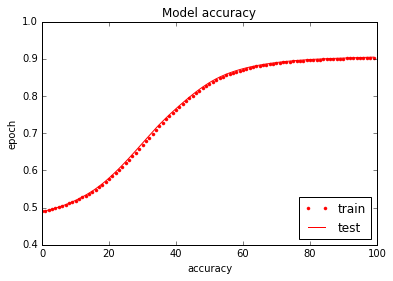

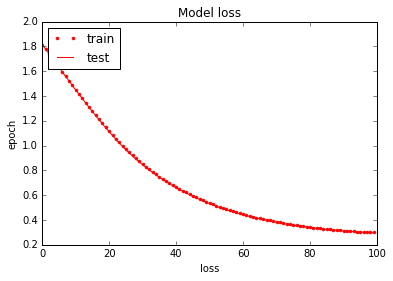

Loading the model ...
Loading data ...
Testing shape: (1277, 160, 160, 5)
Evaluating ...
1277/1277 [==============================] - 11s 8ms/step
loss: 0.30%
jaccard_coef: 5.89%
jaccard_coef_int: 1.10%
acc: 90.34%
Results:
 20 overlap
 30 split for validation
Training shape: (2979, 160, 160, 5)


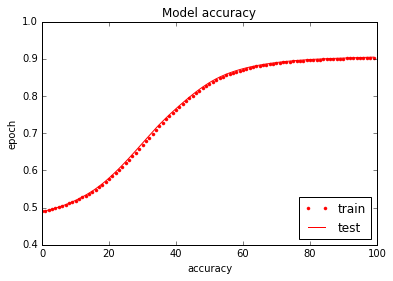

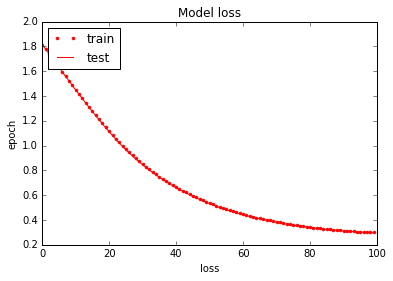

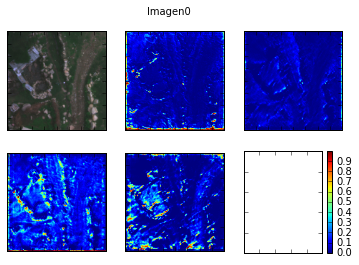

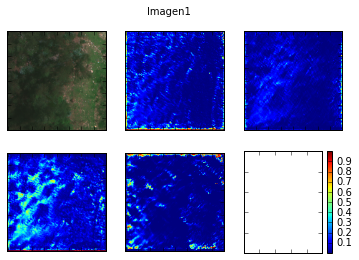

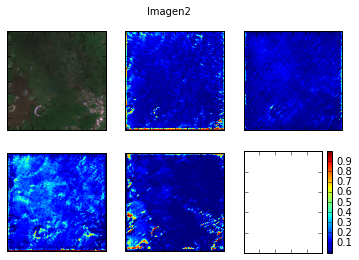

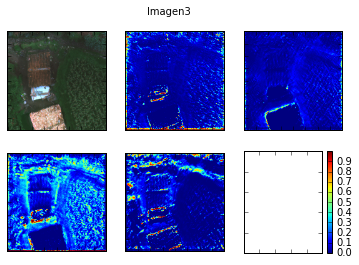

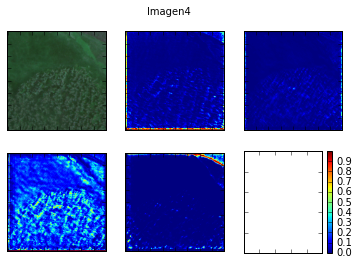

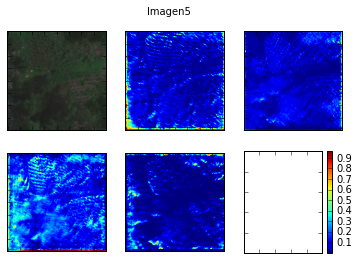

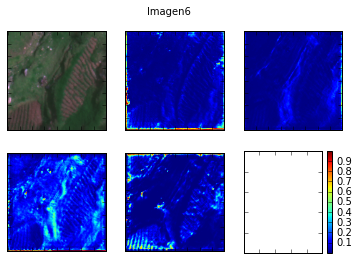

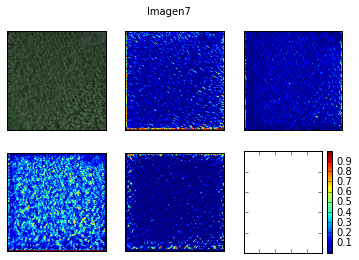

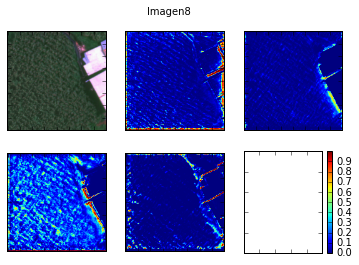

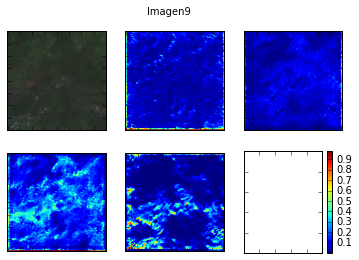

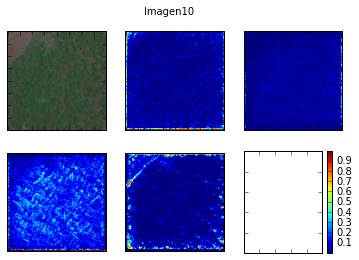

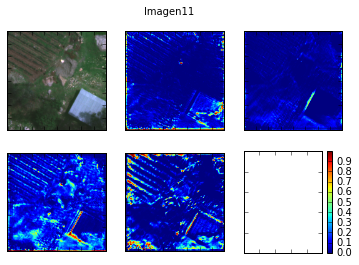

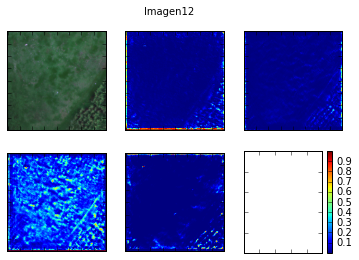

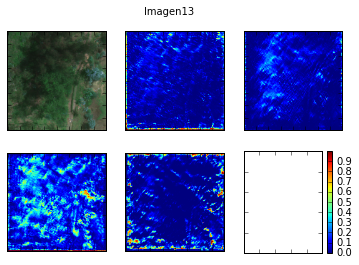

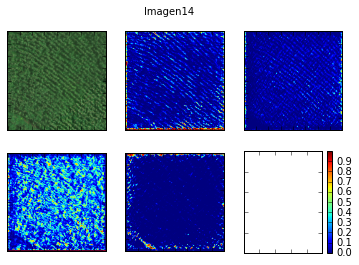

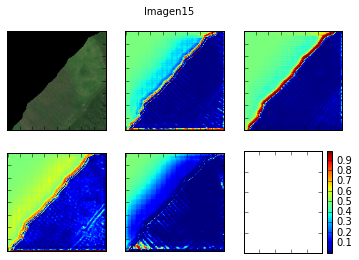

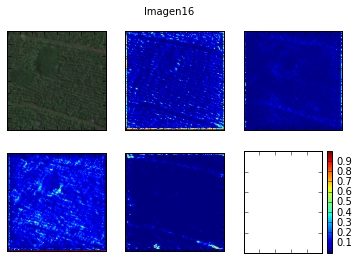

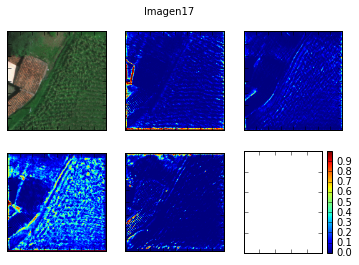

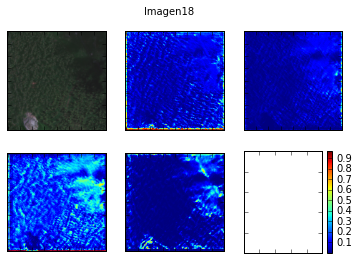

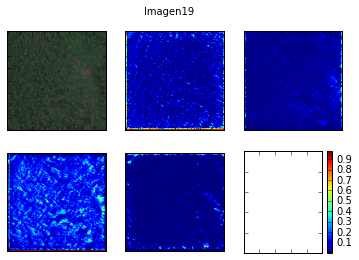

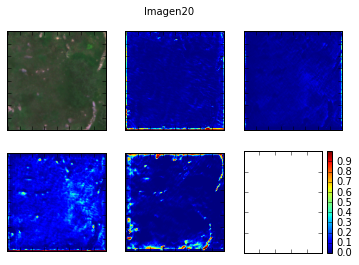

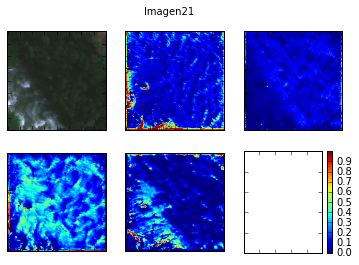

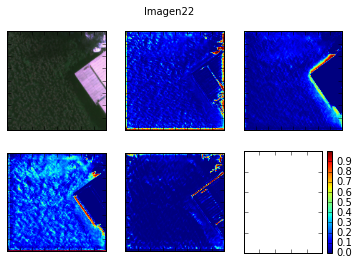

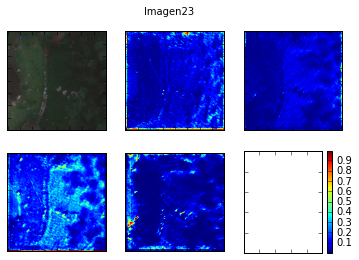

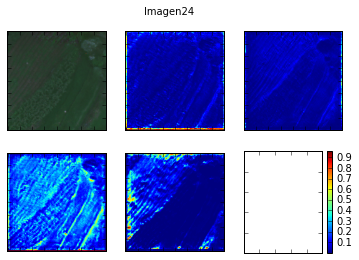

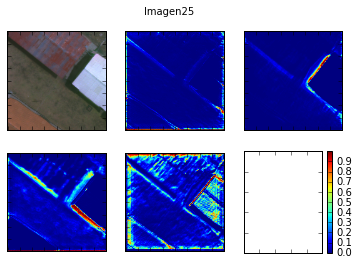

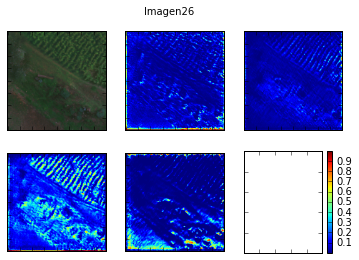

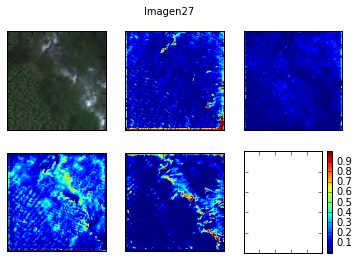

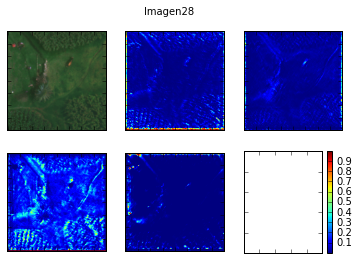

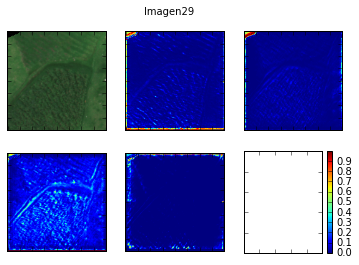

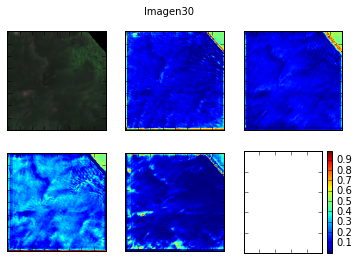

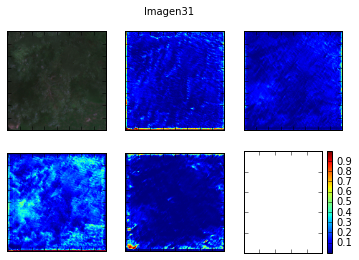

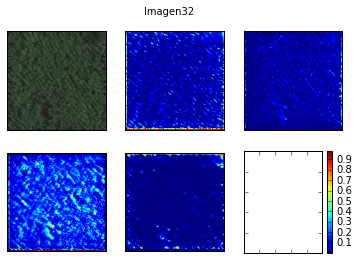

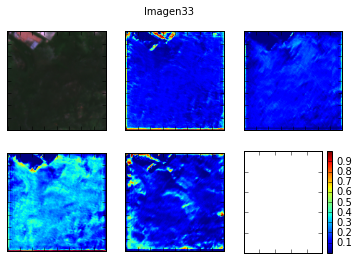

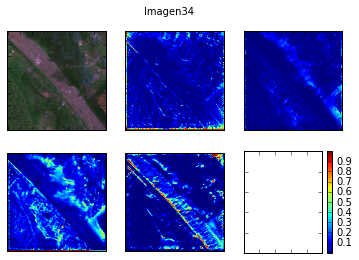

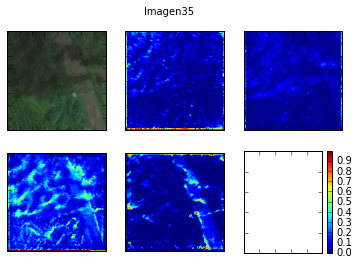

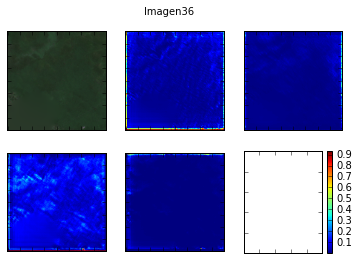

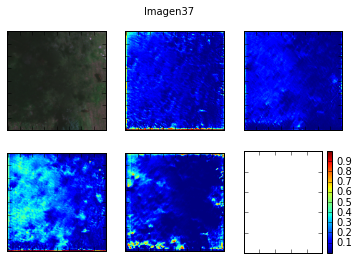

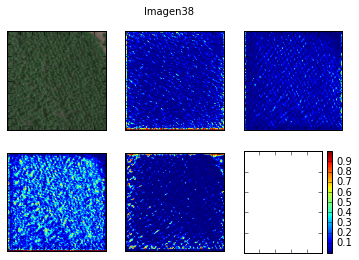

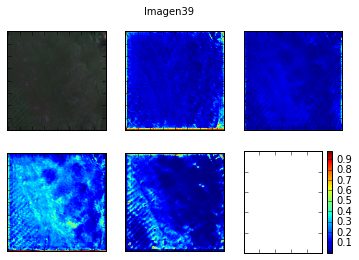

In [186]:
 if __name__ =='__main__':
	option=5 #1: Prepare data  2:Train 3: Predict 4:show Predicted 5:Evaluate test 6:Complete
	
	if (option==1):		
		prepareTotalData() 
		generatePatches() #30%overlap
		splitDB() #80%train 20%test
		
	elif (option==2):
		train_net_parallel() #train U-net
		predictTest()
	elif(option==3):
		predictTest()
	elif(option==4):
		showPredicted()
	elif(option==5):
		predictTest()        
		evaluateModel()
		showPredicted()         
 	elif(option==6):
		#prepareTotalData() 
		#generatePatches() #30%overlap
		#splitDB() #80%train 20%test
		#train_net_parallel() #train U-net
		#predictTest()        
		#evaluateModel()
		#showPredicted()
		loadHist()        
	tf.clear_session()
